<small>Copyright 2025 Amazon.com, Inc. or its affiliates. All Rights Reserved.<br>
This is AWS Content subject to the terms of the Customer Agreement</small>

# Module 2.1: Video Frame Processing Walkthrough

This notebook demonstrates video frame extraction and processing using different sampling methods. We'll explore both traditional sampling (middle/random) and advanced semantic sampling for intelligent frame selection.

## A. Overview

The video frame processing pipeline consists of:
1. **Traditional Sampling** - Middle and random frame selection
2. **Semantic Sampling** - AI-powered scene detection and frame selection
3. **Batch Processing** - Process multiple videos from S3

## B. Install Dependencies

First, let's install the required packages for this notebook.

In [ ]:
!pip install -q matplotlib opencv-python Pillow tqdm

## C. Setup and Imports

First, we'll import all the necessary libraries for video processing, image manipulation, and AWS services. These imports provide the foundation for frame extraction, embedding generation, and visualization.

In [1]:

import json
import os
import random
import base64
from io import BytesIO
import time
from concurrent.futures import ThreadPoolExecutor

import cv2
from PIL import Image
import boto3
from botocore.exceptions import ClientError
import matplotlib.pyplot as plt
import numpy as np

from utils.video_processing import visualize_frames, process_videos_pipeline
from utils.config import get_s3_bucket, discover_video_files

## D. Configuration

Configure your AWS session and video processing parameters. Make sure your video file exists in the specified path and adjust the number of frames based on your analysis needs.

In [2]:
# AWS Configuration
session = boto3.Session()

# Video processing parameters
VIDEO_PATH1 = "generated_videos/video_1.mp4"  # Local video file
VIDEO_PATH2 = "generated_videos/video_2.mp4"  # Local video file
NUM_FRAMES = 16  # Number of frames to extract

## E. Extract All Frames from Video

This section demonstrates how to load a video file and extract all individual frames using OpenCV. We'll convert the video into a list of frame arrays that can be processed by our sampling algorithms.

In [3]:
# Function to extract all frames from a video file
def convert_to_frames(video_path):
    """
    Extract all frames from a video file using OpenCV.
    
    Args:
        video_path (str): Path to the video file
        
    Returns:
        list: List of frame arrays (numpy arrays)
    """
    cap = cv2.VideoCapture(video_path)
    frame_indices_len = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    # Extract all frames from video
    frames = []
    for i in range(frame_indices_len):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if not ret:
            continue
        frames.append(frame)
    return frames

In [4]:
# Load the video and extract all frames
# This creates a list of numpy arrays, one for each frame
frames = convert_to_frames(VIDEO_PATH1)
print(f"📹 Extracted {len(frames)} frames from video1")

frames_long = convert_to_frames(VIDEO_PATH2)
print(f"📹 Extracted {len(frames_long)} frames from video2")

📹 Extracted 145 frames from video1
📹 Extracted 725 frames from video2


## F. Traditional Frame Sampling (Uniform/Random)

Traditional sampling methods divide the video into equal intervals and select frames systematically. **Uniform sampling** selects the middle frame from each interval for consistent representation, while **random sampling** picks frames randomly within each interval for variety. These methods are fast and work well for videos with consistent content.

In [5]:
# Function for uniform frame sampling - selects middle frame from equal intervals
def get_frame_indices_uniform(num_frames, frames):
    """
    Sample frames uniformly by selecting the middle frame from equal intervals.
    
    Args:
        num_frames (int): Number of frames to sample
        frames (list): List of all video frames
        
    Returns:
        list: List of sampled frames
    """
    total_frames = len(frames)
    acc_samples = min(num_frames, total_frames)
    intervals = np.linspace(
        start=0, 
        stop=total_frames, 
        num=acc_samples + 1
    ).astype(int)
    # Create frame ranges for each interval
    ranges = []
    for idx, interv in enumerate(intervals[:-1]):
        ranges.append((interv, intervals[idx + 1] - 1))

    frame_indices = [(x[0] + x[1]) // 2 for x in ranges]

    if len(frame_indices) < num_frames:
        padded_frame_indices = [frame_indices[-1]] * num_frames
        padded_frame_indices[:len(frame_indices)] = frame_indices
        frame_indices = padded_frame_indices

    return [frames[idx] for idx in frame_indices]

In [6]:
# Function for random frame sampling - randomly selects frames from equal intervals
def get_frame_indices_random(num_frames, frames):
    """
    Sample frames randomly by selecting random frames from equal intervals.
    
    Args:
        num_frames (int): Number of frames to sample
        frames (list): List of all video frames
        
    Returns:
        list: List of randomly sampled frames
    """
    total_frames = len(frames)
    acc_samples = min(num_frames, total_frames)
    intervals = np.linspace(
        start=0, 
        stop=total_frames, 
        num=acc_samples + 1
    ).astype(int)
    # Create frame ranges for each interval
    ranges = []
    for idx, interv in enumerate(intervals[:-1]):
        ranges.append((interv, intervals[idx + 1] - 1))

    # Randomly select one frame from each interval
    try:
        frame_indices = [random.choice(range(x[0], x[1])) for x in ranges]
    except:
        # Fallback: random permutation if ranges are invalid
        frame_indices = np.random.permutation(total_frames)[:acc_samples]
        frame_indices.sort()
        frame_indices = list(frame_indices)

    if len(frame_indices) < num_frames:
        padded_frame_indices = [frame_indices[-1]] * num_frames
        padded_frame_indices[:len(frame_indices)] = frame_indices
        frame_indices = padded_frame_indices

    return [frames[idx] for idx in frame_indices]

🎯 Uniform sampling selected 16 frames


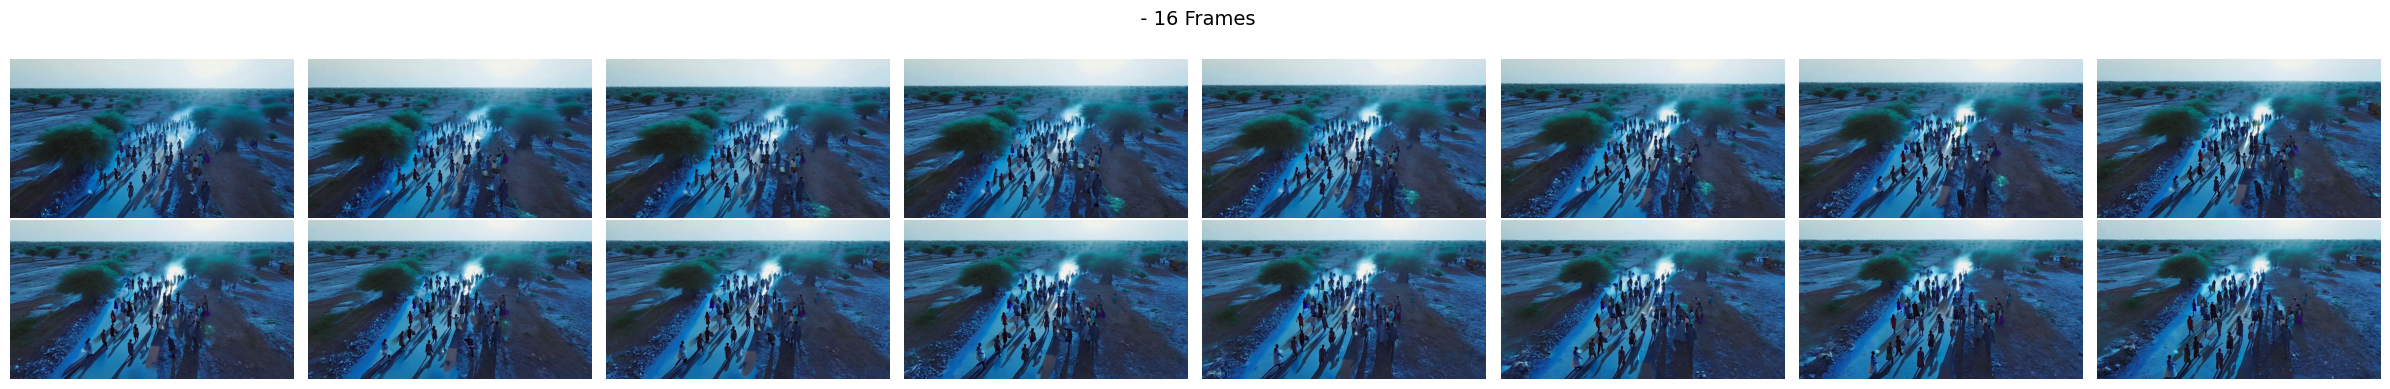

In [7]:
# Apply uniform sampling to select evenly distributed frames
# This method ensures consistent temporal coverage across the video
uniform_sampled_frames = get_frame_indices_uniform(NUM_FRAMES, frames)
print(f"🎯 Uniform sampling selected {len(uniform_sampled_frames)} frames")
visualize_frames(uniform_sampled_frames)

🎲 Random sampling selected 16 frames


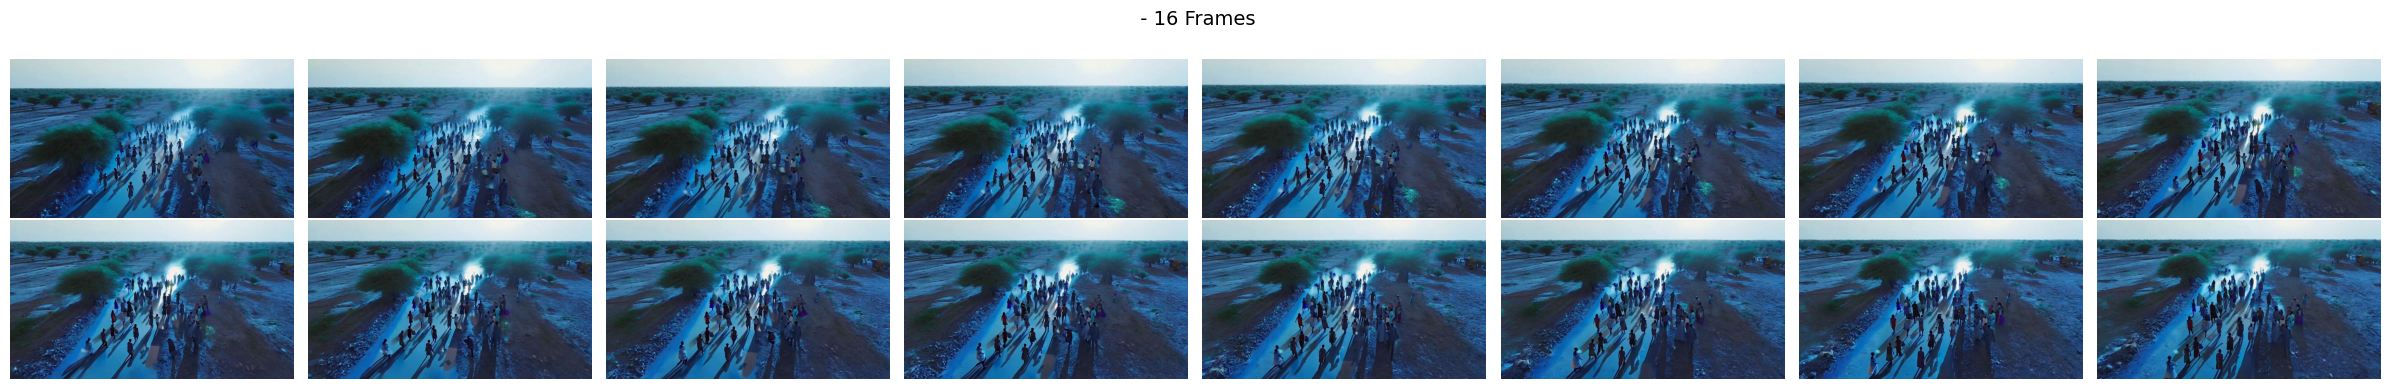

In [8]:
# Apply random sampling for varied frame selection
# This method introduces randomness while maintaining temporal distribution
rand_sampled_frames = get_frame_indices_random(NUM_FRAMES, frames)
print(f"🎲 Random sampling selected {len(rand_sampled_frames)} frames")
visualize_frames(rand_sampled_frames)

## G. Semantic Frame Sampling

Semantic sampling uses AI to understand video content and intelligently select frames. It generates embeddings for each frame using Amazon Titan, calculates similarities between consecutive frames, and identifies scene boundaries where content changes significantly. This method ensures we capture the most representative frames from each distinct scene or segment.

In [9]:
# Function to generate embedding for a single image using Amazon Titan
def get_titan_embedding_image(
        boto3_session, 
        image_base64
    ):
    """
    Generate image embedding using Amazon Titan Embed Image model.
    
    Args:
        boto3_session: AWS boto3 session for API calls
        image_base64 (str): Base64 encoded image string
        
    Returns:
        np.ndarray: 1024-dimensional embedding vector reshaped to (1, 1024)
        None: If all retry attempts fail
    """
    # Initialize Bedrock runtime client
    bedrock_client = boto3_session.client(service_name='bedrock-runtime')
    
    # Create request body for Titan embedding model
    body = json.dumps({
        "inputImage": image_base64,
        "embeddingConfig": {
            "outputEmbeddingLength": 1024
        }
    })

    # Exponential backoff retry strategy
    retry_delays = [1, 2, 4, 8, 16]

    for attempt, delay in enumerate(retry_delays + [None]):
        print(f"inovke Embedding - attempt {attempt}", end = "\r")
        try:
            # Invoke Titan embedding model
            response = bedrock_client.invoke_model(
                body=body,
                modelId="amazon.titan-embed-image-v1",
                accept = "application/json",
                contentType = "application/json"
            )

            # Extract embedding from response
            temp = json.loads(response['body'].read())['embedding']

            return np.array(temp).reshape(1, -1)
        except (ClientError, Exception) as e:
            print(f"ERROR: Can't invoke amazon.titan-embed-image-v1. Reason: {e}")
            if delay is not None:
                time.sleep(delay)  # Wait before retry
            else:
                return None  # All retries exhausted
    return None

# Function to generate embeddings for multiple images in parallel
def get_image_embeddings_parallel(
        boto3_session, 
        frames, 
        max_workers=10
    ):
    """
    Generate embeddings for multiple images in parallel using ThreadPoolExecutor.
    
    Args:
        boto3_session: AWS boto3 session for API calls
        frames (list): List of extracted frames
        max_workers (int): Maximum number of parallel threads (default: 10)
        
    Returns:
        np.ndarray: Stacked embeddings array of shape (num_images, 1024)
    """
    image_base64_list = []
    # Convert frames to base64
    for frame in frames:
        pil_img = Image.fromarray(frame)
        img_buffer = BytesIO()
        pil_img.save(img_buffer, format="PNG")
        img_buffer.seek(0)
        img_str = base64.b64encode(img_buffer.read()).decode('utf-8')
        image_base64_list.append(img_str)

    # Process images in parallel using thread pool
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        embeddings = list(
            executor.map(
                lambda image_base64: get_titan_embedding_image(
                    boto3_session, 
                    image_base64
                ), 
                image_base64_list
            )
        )

    # Stack all embeddings into single array
    embeddings = np.vstack(embeddings)
    
    return embeddings.astype(np.float32)

# Function to calculate cosine similarity between two vectors
def cosine_sim(a, b):
    """
    Calculate cosine similarity between two vectors.
    
    Args:
        a (np.ndarray): First vector
        b (np.ndarray): Second vector
        
    Returns:
        float: Cosine similarity value between -1 and 1
    """
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [10]:
# Function for semantic frame sampling using AI embeddings to detect scene changes
def semantic_frame_sampling(
        num_frames,
        frames,
        embeddings,
        threshold=0.8
    ):
    """
    Perform semantic frame sampling using Amazon Titan embeddings.

    Args:
        num_frames (int): Number of frames per segement
        frames (list): List of video frames
        embeddings (np.ndarray): Pre-computed embeddings for all frames
        threshold (float): Cosine similarity threshold for scene segmentation (default: 0.8)

    Returns:
        list: List of sampled frames representing different scenes
    """

    # Calculate cosine similarities between consecutive frames
    similarities = []
    for i in range(1, embeddings.shape[0]):
        similarities.append(cosine_sim(embeddings[i-1], embeddings[i]))

    # Find segment boundaries where similarity drops below threshold
    segments = []
    start_idx = 0
    
    for i, sim in enumerate(similarities):
        if sim < threshold:  # Scene change detected
            segments.append((start_idx, i + 1))
            start_idx = i + 1
    
    # Add the final segment
    if start_idx < len(embeddings):
        segments.append((start_idx, len(embeddings)))
    
    # Uniformly sample frames within each detected segment
    frame_indices = []
    for seg_idx, (start, end) in enumerate(segments):
        seg_len = end - start
        # Distribute frames evenly across segments
        seg_samples = max(1, min(num_frames, seg_len))
        
        # Create uniform intervals within segment
        intervals = np.linspace(start, end, seg_samples + 1).astype(int)
        # Select middle frame from each interval
        seg_indices = [(intervals[i] + intervals[i + 1] - 1) // 2 for i in range(len(intervals) - 1)]

        display_string = ",".join([str(x) for x in seg_indices])
        print(f"Segment {seg_idx}: {display_string}")
        
        frame_indices += seg_indices

    return [frames[idx] for idx in frame_indices]

In [11]:
# Generate embeddings for all frames using Amazon Titan
# This step converts each frame into a 1024-dimensional vector representation
print(f"🧠 Generating embeddings for {len(frames_long)} frames...")
embeddings = get_image_embeddings_parallel(
        session, 
        frames_long, 
        max_workers=10
    )
print(f"✅ Generated embeddings with shape: {embeddings.shape}")

🧠 Generating embeddings for 725 frames...
✅ Generated embeddings with shape: (725, 1024) attempt 0inovke Embedding - attempt 0


<font color='blue' size = 4>Now we have generated embeddings for all frames. Next, we need to set a threshold of similarities between consecutive frames, so we could use this threshold to determine the boundary of different scene.</font>



In [12]:
NUM_FRAMES_PER_SEGMENT = 4

- <font color='red'>Feel free adjust the threshold value below and see how different threshold impact video segementation</font>

🤖 Applying semantic sampling with threshold=0.1...
Segment 0: 90,271,452,633
🎬 Semantic sampling selected 4 frames,
	1 segments,
	4 for each segment


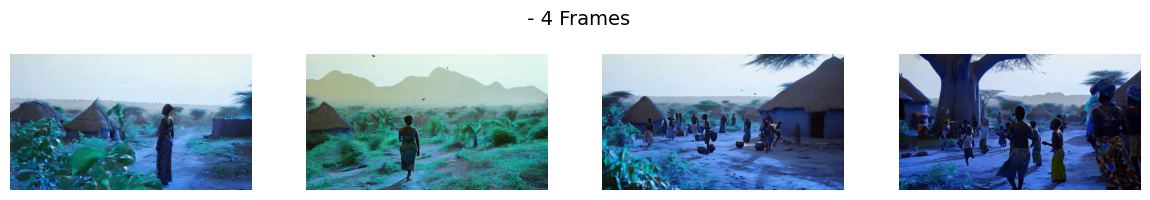

In [13]:
threshold = 0.1
print(f"🤖 Applying semantic sampling with threshold={threshold}...")
semantic_sampled_frames = semantic_frame_sampling(
        NUM_FRAMES_PER_SEGMENT,
        frames_long,
        embeddings,
        threshold=threshold
    )
print(f"🎬 Semantic sampling selected {len(semantic_sampled_frames)} frames,\n\t{int(len(semantic_sampled_frames)/NUM_FRAMES_PER_SEGMENT)} segments,\n\t{NUM_FRAMES_PER_SEGMENT} for each segment")
visualize_frames(
    semantic_sampled_frames,
    max_frames_per_row = 4
)

🤖 Applying semantic sampling with threshold=0.8...
Segment 0: 17,53,89,126
Segment 1: 162,198,234,271
Segment 2: 307,343,379,416
Segment 3: 470,543,615,688
🎬 Semantic sampling selected 16 frames,
	4 segments,
	4 for each segment


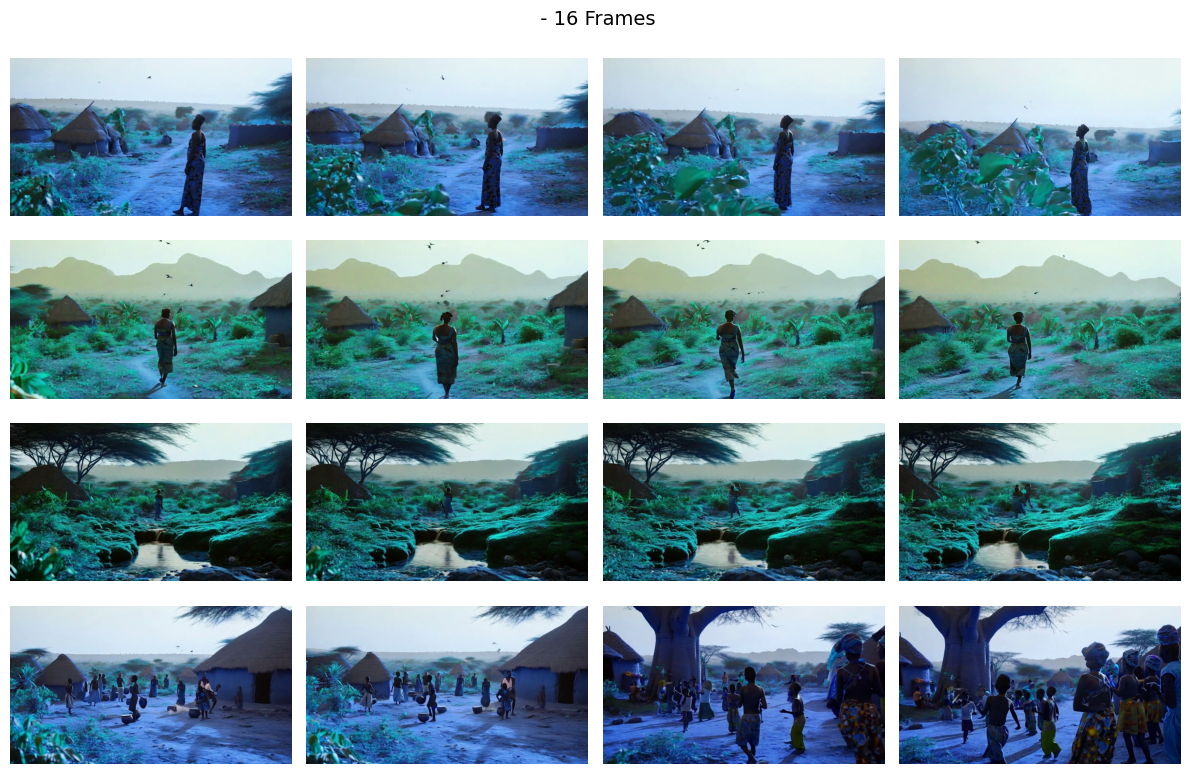

In [14]:

threshold = 0.8
print(f"🤖 Applying semantic sampling with threshold={threshold}...")
semantic_sampled_frames = semantic_frame_sampling(
        NUM_FRAMES_PER_SEGMENT,
        frames_long,
        embeddings,
        threshold=threshold
    )
print(f"🎬 Semantic sampling selected {len(semantic_sampled_frames)} frames,\n\t{int(len(semantic_sampled_frames)/NUM_FRAMES_PER_SEGMENT)} segments,\n\t{NUM_FRAMES_PER_SEGMENT} for each segment")
visualize_frames(
    semantic_sampled_frames,
    max_frames_per_row = 4
)

🤖 Applying semantic sampling with threshold=0.9...
Segment 0: 17,53,89,126
Segment 1: 162,198,234,271
Segment 2: 307,343,379,416
Segment 3: 452,488,524,561
Segment 4: 597,633,669,706
🎬 Semantic sampling selected 20 frames,
	5 segments,
	4 for each segment


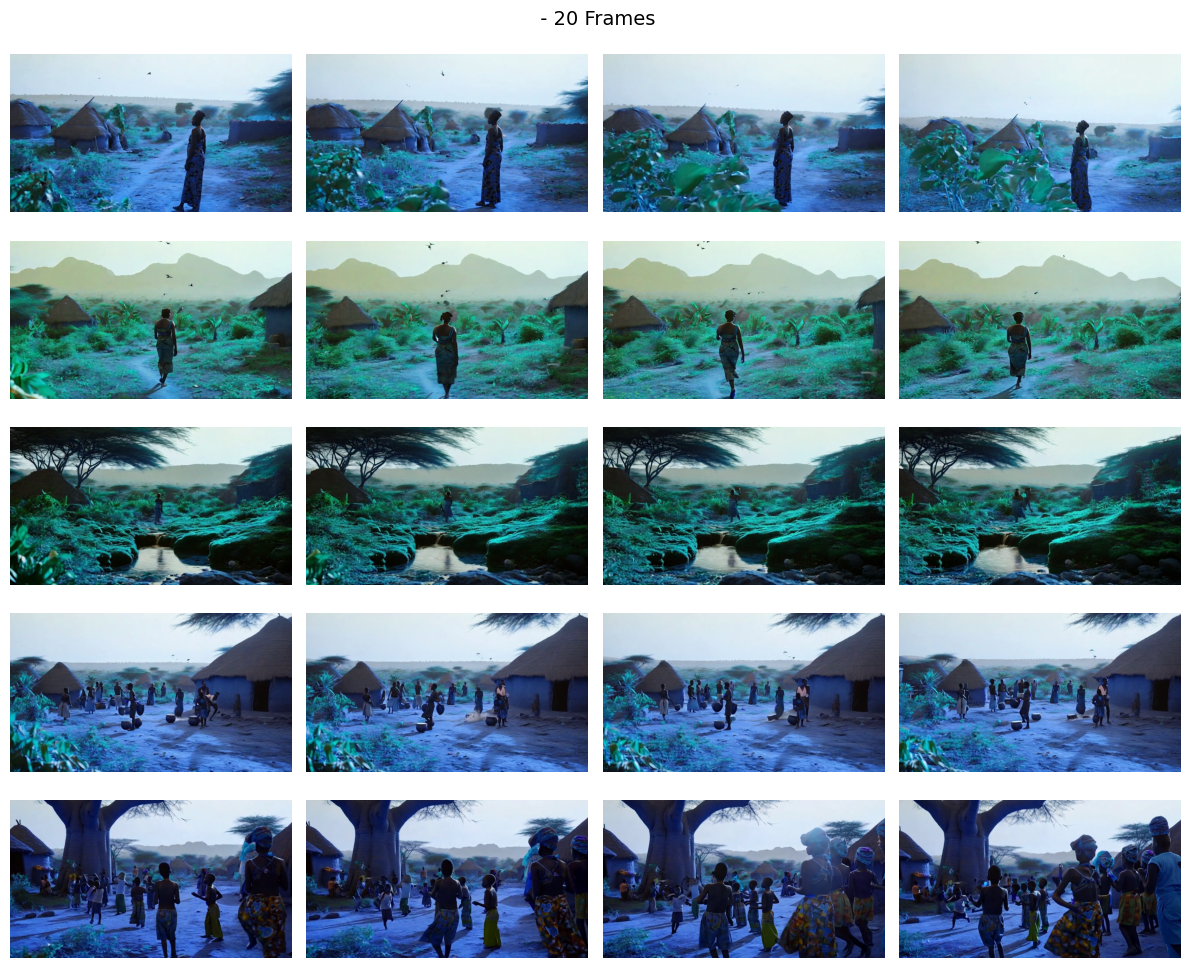

In [15]:
# Apply semantic sampling using AI-powered scene detection
# Lower threshold = more sensitive to scene changes (more segments)
# Higher threshold = less sensitive (fewer segments)
threshold = 0.9
print(f"🤖 Applying semantic sampling with threshold={threshold}...")
semantic_sampled_frames = semantic_frame_sampling(
        NUM_FRAMES_PER_SEGMENT,
        frames_long,
        embeddings,
        threshold=threshold
    )
print(f"🎬 Semantic sampling selected {len(semantic_sampled_frames)} frames,\n\t{int(len(semantic_sampled_frames)/NUM_FRAMES_PER_SEGMENT)} segments,\n\t{NUM_FRAMES_PER_SEGMENT} for each segment")
visualize_frames(
    semantic_sampled_frames,
    max_frames_per_row = 4
)

## H. Complete Video Processing Pipeline - Putting It All Together

**Important Note**: Amazon Nova models have built-in video processing capabilities that automatically handle uniform frame sampling when videos are loaded for analysis. For videos less than 16 minutes, the default sampling rate is 1 frame per second. 


The `process_videos_pipeline()` function serves as the second component of the ROBO-reviewer, downloading videos from S3, performing intelligent scene segmentation, and uploading structured results back to S3. Since Nova handles frame sampling internally (https://docs.aws.amazon.com/nova/latest/userguide/modalities-video.html), this pipeline focuses exclusively on scene segmentation - a critical capability for evaluating videos containing multiple distinct scenes where individual scene analysis provides more accurate assessment results.



**Key Operations**:

2. **AI-driven scene segmentation** - Uses Amazon Titan embeddings to automatically detect scene changes based on visual similarity thresholds
3. **Batch S3 processing** - Downloads videos from S3 URIs, processes locally, and uploads structured results back to S3
4. **Organized output structure** - Creates systematic folder hierarchy with separate videos for each sampling method and detected scene segment

  

**Output Structure**:

The pipeline focuses on semantic segmentation since Nova handles uniform/random sampling automatically. Results are saved to S3 with this structure:

```
s3://<your bucket>/
└── generated_videos/
    ├── <generated video file>.mp4
    └── <generated video file>/
        └── semantic/                    # Semantic segmentation results
            ├── 0_video.mp4             # Segment 0 - Complete scene segment
            ├── 1_video.mp4             # Segment 1 - Complete scene segment
            ├── 2_video.mp4             # Segment 2 - Complete scene segment
            └── ...                     # Additional segments as detected
```

**Note**: Uniform and random sampling outputs are commented out in the pipeline since Nova models perform these operations automatically with optimized strategies.

In [ ]:

# Get S3 bucket name
S3_BUCKET = get_s3_bucket(session)

# Load configuration for video prefix
with open('config.json', 'r') as f:
    config = json.load(f)

available_videos = discover_video_files(
    session, 
    S3_BUCKET, 
    config['video_prefix']
)

# Example S3 URIs - replace with your actual video names
video_names = available_videos[0:2]  # Replace with your video names
s3_uris = [f"s3://{S3_BUCKET}/{config['video_prefix']}{name}" for name in video_names]

In [ ]:
process_videos_pipeline(
    session,
    s3_uris,
    num_frames = 16,  # number of sampled frames
    threshold = 0.9  # threshold for segmenting video through semantic
)

## Conclusion

You've successfully learned about:

1. **Amazon Nova's automatic sampling** - Understanding how Nova models handle video processing internally
2. **Traditional sampling methods** (uniform/random) for analysis and comparison
3. **Semantic sampling** for intelligent scene segmentation and content-aware processing
4. **Production pipeline** that creates structured video segments for downstream evaluation

Now you can move to the next module to see how to evaluate the quality of videos.